# Model for predicting Second Language Adquisiton

We start by loading the necessary libraries.

In [1]:
from fastai.data.all import *
from fastai.learner import *
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import Adam, OptimWrapper, params
from fastai.metrics import accuracy, F1Score
from fastai.torch_core import *
from fastai.torch_imports import *
from transformers import AutoModelForSequenceClassification
import pandas as pd
from blurr.text.data.core import *
from blurr.text.modeling.core import *
from blurr.text.utils import NLP as BLURR # lo importamos así para que sea compatible con el resto
from datasets import load_dataset, concatenate_datasets

/home/jonathan/.virtualenvs/huggingface/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
import torch
torch.cuda.set_device(3)

Now, we load the train and validation sets.

In [3]:
train_df = pd.read_csv('perplejidad/datasets/train_train_set.csv',delimiter='\t')

In [4]:
valid_df = pd.read_csv('perplejidad/datasets/validation_train_set.csv',delimiter='\t')

In [5]:
len(train_df),len(valid_df)

(33684, 3743)

In [6]:
train_df['is_valid']=False

In [7]:
valid_df['is_valid']=True

In [8]:
train_valid_df = pd.concat([train_df,valid_df])

We define the indexes for training and validation.

In [9]:
train_idxs, valid_idxs = L(range(len(train_valid_df[train_valid_df.is_valid==False]))), L(range(len(train_valid_df[train_valid_df.is_valid==False]), len(train_valid_df)))

Now, we can define the model. In this case, we use a predefined model called Roberta.

In [14]:
dl_kwargs = {"bs": 96, "val_bs": 64}
learn_kwargs = {"metrics": [accuracy]}

In [11]:
learn = BlearnerForSequenceClassification.from_data(
    train_valid_df,
    "bertin-project/bertin-roberta-base-spanish",
    text_attr="Sentence",
    label_attr="Level",
    dblock_splitter=IndexSplitter(valid_idxs),
    dl_kwargs=dl_kwargs,
    learner_kwargs=learn_kwargs,
)

In [14]:
learn = learn.to_fp16()

In [15]:
learn.dls.show_batch(dataloaders=learn.dls, trunc_at=500, max_n=5)

,text,target
0,"Tengo muchos libros y novels que le gustan mucho l'insupportable_legerete_de_l_etre de Milan_Kundera, mille_et_un_soleils_splendides , je_ne_suis_pas_celle_que_je_suis de una irani escritora e un libro de un escritor español Javier_Marias Un_Coeur_si_blanc ...",A1
1,UN dìa por la noche a las 3:00_de_la_mañana estuve revisiando y de un golpe un nùmero me quedè en mi cabeza que es el 56. y es nùmero de nombre en la lista de los aprovechados de el bachellirato.,B1
2,"Conesco a un nobelista muy famoso, es Mohamed_Chokri, nacié en 1935 a Beni_chiker, en el Hoceima. a el ciete años siguientes, la miseria empujó su familia a emigrar a Tanger en 1942.",A2
3,"Tengo un hermena jemela que se llama SARAH es muy serviciable+tiene serviciable+tiene 23 23+años y tiene un chico de 2 años, y tengo un autra hermana aue se+lla ma se+lla ma SOFIA es nerviosa y tiene 16 años.",A1
4,"Tambien tengo dos hermanos, una+hermana una+hermana que mora en Nova_Zelandia e un hermano que mora junto comigo, elles se llaman Giovanna y Adriano y mi mammà e pappà se llaman Vergìnia y Ricardo.",A1


In [16]:
learn.fine_tune(10,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.252666,1.204901,0.496928,00:24


epoch,train_loss,valid_loss,accuracy,time
0,0.681092,0.614156,0.771574,00:36
1,0.532158,0.613698,0.763559,00:38
2,0.409064,0.671578,0.765963,00:41
3,0.280920,0.700277,0.766497,00:38
4,0.166685,0.938951,0.762490,00:40
5,0.099622,1.067919,0.770238,00:41
6,0.050670,1.156242,0.784398,00:41
7,0.022505,1.362780,0.784398,00:40
8,0.007809,1.631428,0.786535,00:41
9,0.001731,1.690390,0.785466,00:41


In [17]:
learn.export('roberta.pkl')

In [18]:
learn.save('roberta-new')

Path('models/roberta-new.pth')

In [8]:
test_df = pd.read_csv('perplejidad/datasets/test_set.csv',delimiter='\t')

In [9]:
test_df['is_valid']=True

In [10]:
len(train_df)

33684

In [11]:
train_test_df = pd.concat([train_df,test_df])

In [12]:
train_idxs, test_idxs = L(range(len(train_test_df[train_test_df.is_valid==False]))), L(range(len(train_test_df[train_test_df.is_valid==False]), len(train_test_df)))

In [15]:
learnTest = BlearnerForSequenceClassification.from_data(
    train_test_df,
    "bertin-project/bertin-roberta-base-spanish",
    text_attr="Sentence",
    label_attr="Level",
    dblock_splitter=IndexSplitter(test_idxs),
    dl_kwargs=dl_kwargs,
    learner_kwargs=learn_kwargs,
)

In [16]:
learnTest.load('roberta-new')

In [17]:
learnTest.validate()

(#2) [1.6924549341201782,0.7845463156700134]

In [18]:
preds,gt=learnTest.get_preds()

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [20]:
cm = confusion_matrix(gt, np.argmax(preds,axis=1))

In [21]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=learnTest.dls.vocab)

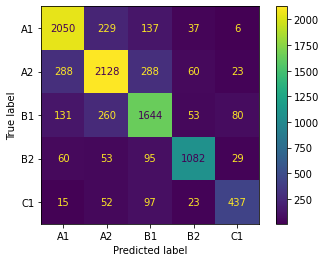

In [22]:
disp.plot()

In [29]:
for i,(x,y) in enumerate(zip(gt,np.argmax(preds,axis=1))):
    if((x==4) and (y==1)):
        print(test_df.iloc[i].Sentence)

6458
Me llamo Elizabeth_Bach .


In [30]:
for i,(x,y) in enumerate(zip(gt,np.argmax(preds,axis=1))):
    if((x==3) and (y==0)):
        print(test_df.iloc[i].Sentence)

Holla , buenas noches !
 a_solas
soludos cordeales ,
Departamento de Geografía .


In [31]:
for i,(x,y) in enumerate(zip(gt,np.argmax(preds,axis=1))):
    if((x==1) and (y==4)):
        print(test_df.iloc[i].Sentence)

Me llamo Cristina_Olegovna_Lim.
Estimados señores .


In [23]:
learnTest.predict("Jordan, es una persona positiva para las mujeres y ha dado poder a las hembras a través de su trabajo.Lo que me hace reír sobre Jordan es que no tiene talento alguno pero ella lo admita. Al menos es honesta. No obstante, muchos dicen ¿por qué tenemos que soportar el constante influjo de imágenes que son pornográficas en los periódicos?")

[{'label': 'A',
  'score': 0.6228625178337097,
  'class_index': 1,
  'class_labels': ['A1', 'A2', 'B1', 'B2', 'C1'],
  'probs': [8.605072210343678e-09,
   0.6228625178337097,
   2.4195525838877074e-05,
   1.1379589750504238e-06,
   0.37711209058761597]}]

In [24]:
learnTest.predict("En esta historia,  Había un pobre hombre en un  mal lugar en algúna ciudad,  cuando era en la calle, había hubierto un niño. Este hombre se llevaba y se ponía en un coche con otro niño pero la madre del niño veía a él y rechazaba a este niño. ")

[{'label': 'B',
  'score': 0.9998704195022583,
  'class_index': 2,
  'class_labels': ['A1', 'A2', 'B1', 'B2', 'C1'],
  'probs': [2.592609016360825e-09,
   8.563458386845468e-09,
   0.9998704195022583,
   1.0987124099415269e-08,
   0.0001295993133680895]}]

In [25]:
learnTest.predict("Yo tengo hablar de Gwen Stefani. Gwen Stafani es una performa muisca. Ella es muy bonita y intilligete. Su musica es bella y divertida. Es con Gavin Rosdalle. Ella es una madre nueve. Su hermano nombre es Kingston. Ella es solo performo ahora pero was en el groupo musico No Doubt. Tienen mucho music popular. ")

[{'label': 'A',
  'score': 0.9999922513961792,
  'class_index': 1,
  'class_labels': ['A1', 'A2', 'B1', 'B2', 'C1'],
  'probs': [7.707758413744159e-06,
   0.9999922513961792,
   1.3555282230015564e-08,
   1.709708152830558e-09,
   3.2217810641554934e-09]}]

In [13]:
learn.load('roberta')

In [14]:
preds,gt=learn.get_preds()

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [16]:
cm = confusion_matrix(gt, np.argmax(preds,axis=1))

In [18]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=learn.dls.vocab)

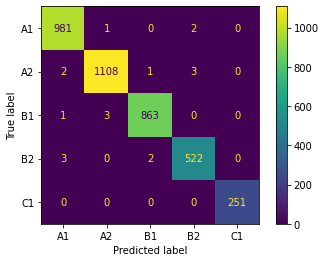

In [19]:
disp.plot()

In [20]:
learn.validate()

(#2) [0.02482208050787449,0.9951910376548767]

In [22]:
len(valid_df)

3743

In [24]:
learn.predict('Está todo loco')

[{'label': 'A',
  'score': 0.856852114200592,
  'class_index': 1,
  'class_labels': ['A1', 'A2', 'B1', 'B2', 'C1'],
  'probs': [0.1270863115787506,
   0.856852114200592,
   0.015130816027522087,
   0.0002736821479629725,
   0.0006571081466972828]}]